In [12]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

import requests
import random

In [13]:
load_dotenv()

True

In [14]:
import os
def get_groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7, max_tokens=2000
    )

llm = get_groq_llm()

In [15]:
# Tools
search_tool = DuckDuckGoSearchRun(region="us-en")

@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}


@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA') 
    using Alpha Vantage with API key in the URL.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=C9PE94QUEW9VWGFM"
    r = requests.get(url)
    return r.json()


In [16]:
# Make tool list
tools = [get_stock_price, search_tool, calculator]

# Make the LLM tool-aware
llm_with_tools = llm.bind_tools(tools)

In [17]:
# state
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [18]:
# graph nodes
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call."""
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)  # Executes tool calls

In [19]:
# graph structure
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

In [20]:
graph.add_edge(START, "chat_node")

# If the LLM asked for a tool, go to ToolNode; else finish
graph.add_conditional_edges("chat_node", tools_condition)

graph.add_edge("tools", "chat_node")    

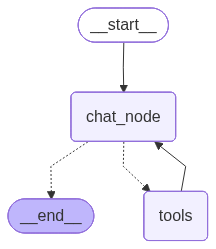

In [21]:
chatbot = graph.compile()

chatbot

In [22]:
# Regular chat
out = chatbot.invoke({"messages": [HumanMessage(content="Hello!")]})

print(out["messages"][-1].content)


Hello! How can I help you today?


In [24]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="What is 2*3?")]})
print(out["messages"][-1].content)

6


In [25]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="What is the stock price of apple")]})
print(out["messages"][-1].content)

The latest price for Apple (AAPL) is **$273.76** per share (as of the most recent trading day).


In [26]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="First find out the stock price of Apple using get stock price tool then use the calculator tool to find out how much will it take to purchase 50 shares?")]})
print(out["messages"][-1].content)

**Apple (AAPL) – Current Price (as of 2025‑12‑29)**  
- **Price per share:** **$273.76**

**Cost to purchase 50 shares**

\[
273.76 \times 50 = \$13{,}688.00
\]

So, it would take **$13,688** to buy 50 shares of Apple at the current price.


In [27]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="who is the ceo of Youtube & what is his twitter handle?")]})
print(out["messages"][-1].content)

**CEO of YouTube:**  
- **Name:** Neal Mohan  
- **Twitter handle:** **@nealmohan**  

Neal Mohan has been the chief executive officer of YouTube since 2023, succeeding Susan Wojcicki. His official Twitter account is @nealmohan.
